# Assignment 1

**Content-Based Image Retrieval**


Similar Image Retrieval (aka Content-Based Image Retrieval or CBIR) is any search that involves images.
Nowadays the "Search by photo" approach is being used more and more actively, in particular, in e-commerce services (AliExpress, Wildberries, etc.). "Keyword search" (with an understanding of the content of images) has long settled in the search engines Google, Yandex, etc.,

**How does it work ?**


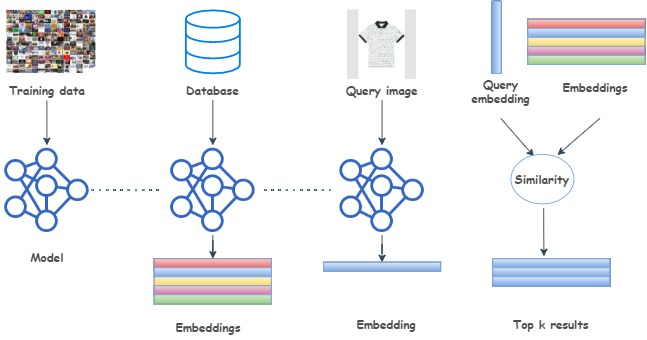


As you can see the pipeline seems easy. First we need a dataset, in this assignment we will be using a large scale benchmark dataset called the Inshop dataset (use the one provided in the link ;) ). The dataset contains training set and testing set. The testing set is divided into two parts query images and gallery images. The query set basically contains images that we will be searching for in the gallery set.


 
**Steps:**
1. Download the dataset 
2. Read the dataset and put it in an appropriate format 
3. Choose a model (you can use pretrained ;) ) and train it
4. Wisely choose a loss function in deep metric learning there are many such as : Contrastive loss, Triplet loss, multi similarity loss, XBM .... Implement one of them. 
5. Measure the scores using the recall metric
6. Report results ( recall values , loss) using tensorboard or Comet or any tool you are comfortable with.  


**Bonus tasks**



1.   Use of hard negative miner (15 points)
2.   Use of PytorchLightening (10 points)




In [3]:
from IPython.display import clear_output

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_metric_learning
clear_output()

In [26]:
import os
import torch
import time
import torch.optim as optim
from torchvision import transforms, models
import numpy as np
import torchvision
import torch
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from PIL import Image
from random import choice
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_metric_learning.losses import NormalizedSoftmaxLoss

# Recall metric

In [4]:
class RecallMetric(object):
    def __init__(self, feats, labels):

        """
         This function calculates the recall metric

         feats = [gallery_embeddings, query_embeddings]
         labels = [gallery_labels, query_labels]
        """
        self.is_equal_query = False
        self.gallery_feats, self.query_feats = feats
        self.gallery_labels, self.query_labels = labels
        self.sim_mat = np.matmul(self.query_feats, np.transpose(self.gallery_feats))

    def recall_at_k(self, k=1):
        m = len(self.sim_mat)
        match_counter = 0
        for i in range(m):
            pos_sim = self.sim_mat[i][self.gallery_labels == self.query_labels[i]]
            neg_sim = self.sim_mat[i][self.gallery_labels != self.query_labels[i]]
            thresh = np.sort(pos_sim)[-2] if self.is_equal_query else np.max(pos_sim)
            if np.sum(neg_sim > thresh) < k:
                match_counter += 1
        return float(match_counter) / m

## Read data

In [5]:
# connecting to the drive with manga dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip drive/MyDrive/data.zip
clear_output()

In [102]:
 class ImagesDataset(Dataset):
    """Manga dataset"""
    
    def __init__(self, path='data'):
        self.dataset = list(map(str, Path(path).rglob("*.jpg")))
        items = set(map(lambda x: x.split(os.sep)[-2], self.dataset))
        self.name_to_label = dict(zip(items, range(len(items))))
        self.transform = transforms.Compose([
                    transforms.Resize((200, 200)),
                    transforms.ToTensor(),
                ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.dataset[idx]
        class_ = self.name_to_label[img_path.split(os.sep)[-2]]
        with Image.open(img_path) as img:

            rgb_img = Image.new("RGB", img.size)
            rgb_img.paste(img)
            img = rgb_img

            return (self.transform(img), class_)

In [111]:
# Following the tutorial from https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html
class ImageRetreivalDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "data", batch_size: int = 64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_size = 0.8
        self.test_size = 0.1

    def setup(self, stage=None):
        data_full = ImagesDataset()
        # Cropping for debug purpoces
        # data_full, _ = random_split(data_full, [int(len(data_full)*0.1), len(data_full) - int(len(data_full)*0.1)])
        train_size = int(len(data_full)*self.train_size)
        test_size = int(len(data_full)*self.test_size)
        val_size = len(data_full) - train_size - test_size
        self.image_retr_train, test_val = random_split(data_full, [train_size, test_size + val_size])
        self.image_retr_test, self.image_retr_val = random_split(test_val, [test_size, val_size])
    
    def train_dataloader(self):
        return DataLoader(self.image_retr_train, batch_size=self.batch_size, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.image_retr_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.image_retr_test, batch_size=self.batch_size, num_workers=4)

## Model & loss function

In [112]:
device = "cuda:0"

# Following the tutorial from https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html

class EmbeddingModel(pl.LightningModule):
    def __init__(self):
        # model based on the model from paper https://paperswithcode.com/paper/making-classification-competitive-for-deep
        super().__init__()
        self.loss = NormalizedSoftmaxLoss(num_classes=103, embedding_size=2048).to(device)
        self.model = models.resnet50(pretrained=True)

        # # changing the first layer to accept 1 channel images
        # self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.norm = nn.LayerNorm(1000)
        self.out = nn.Linear(1000, 2048, bias=False)
        
    def forward(self, x):
        x = self.model(x)
        x = self.norm(x)
        return self.out(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        emb = self(x)
        loss = self.loss(emb, y)
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        emb = self(x)
        loss = self.loss(emb, y)
        torch.cuda.empty_cache()
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        emb = self(x)
        loss = self.loss(emb, y)
        torch.cuda.empty_cache()
        return loss

    def configure_optimizers(self):
        # SGD for some reason appeared to be way more effective for the dataset
        return torch.optim.SGD(list(self.parameters()) + list(self.loss.parameters()), lr=0.01, weight_decay=.0001, momentum=0.9)
        # Adam, on the other hand, was seen to be useless compared with SGD
        # return torch.optim.Adam(list(self.parameters()) + list(self.loss.parameters()), lr=0.01)

In [115]:
# Training model
train_loader = ImageRetreivalDataModule()
trainer = pl.Trainer(max_epochs=5, gpus=1, log_every_n_steps=1)
model = EmbeddingModel()

trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/optim/sgd.py:95: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(SGD, self).__init__(params, defaults)

  | Name  | Type                  | Params
------------------------------------------------
0 | loss  | NormalizedSoftmaxLoss | 210 K 
1 | model | ResNet                | 25.6 M
2 | norm  | LayerNorm             | 2.0 K 
3 | out   | Linear                | 2.0 M 
------------------------------------------------
27.8 M    Trainable params
0         Non-trainable params
27.8 M    Total params
111.272   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [119]:
torch.save(model, 'model.pt')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [120]:
# Evaluating query and gallery once again to put them to annoy
model.eval()
model.to(device)

data_gallery = ImagesDataset()
# data_gallery = torch.utils.data.Subset(data_gallery, range(0, int(0.1*len(data_gallery))))
gallery_loader = DataLoader(data_gallery, batch_size=64)

g_images, g_labels, g_embeddings = [], [], []

with torch.no_grad():
    for idx, data in enumerate(gallery_loader):
        
        images, labels = data

        g_labels.extend(list(map(lambda x: x.item(), labels)))

        g_images.extend(images.numpy())

        g_embeddings.extend(model(images.to(device)).cpu().numpy())

        if idx % 10  == 0:
            print(f"{idx}/{len(gallery_loader)}")

data_query = ImagesDataset('data/боевик/Боруто')
# data_query =  torch.utils.data.Subset(data_query, range(0, int(0.1*len(data_query))))
query_loader = DataLoader(data_query, batch_size=64)

q_images, q_labels, q_embeddings = [], [], []

with torch.no_grad():
    for idx, data in enumerate(query_loader):
        
        images, labels = data

        q_labels.extend(list(map(lambda x: x.item(), labels)))

        q_images.extend(images.numpy())

        q_embeddings.extend(model(images.to(device)).cpu().numpy())
        if idx % 10  == 0:
            print(f"{idx}/{len(query_loader)}")

g_images = np.asarray(g_images)

0/34
10/34
20/34
30/34
0/1


In [127]:
# Printing recalls
recall = RecallMetric([np.asarray(g_embeddings), np.asarray(q_embeddings)], [np.asarray(g_labels), np.asarray(q_labels)])
print(recall.recall_at_k(k=1), recall.recall_at_k(k=5), recall.recall_at_k(k=10))

0.0 0.0 0.0


## visualization 


Use a retrieval technique like KNN, annoy, KD-tree (you are free to choose). 

Plot 3 query images with their respective top 5 results 


In [124]:
!pip install annoy

     |████████████████████████████████| 646 kB 7.9 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391672 sha256=2372081abae326ea3d46c4c05c7b1ca6f4da6c60210137e45702b31818a28e69
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [128]:
from matplotlib import pyplot as plt
from annoy import AnnoyIndex

In [135]:
# Innopolis University Introduction to Computer Vision labs useful code
def showInRow(list_of_images, titles = None, disable_ticks = False, figsize=(10,25)) :
    count = len(list_of_images)
    plt.figure(figsize=figsize)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])
      
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        # For some reason, the 3rd dimension is movet to the first in original images
        subplot.imshow(np.moveaxis(img, 0, -1), cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

In [131]:
trees = 10
dist = 'angular'
# Making Annoy Index of 10 trees, with 2048 features
index = AnnoyIndex(2048, dist)

for idx, item in enumerate(g_embeddings):
    index.add_item(idx, item)

index.build(trees)

queries = [q_embeddings[0], q_embeddings[10], q_embeddings[20]]

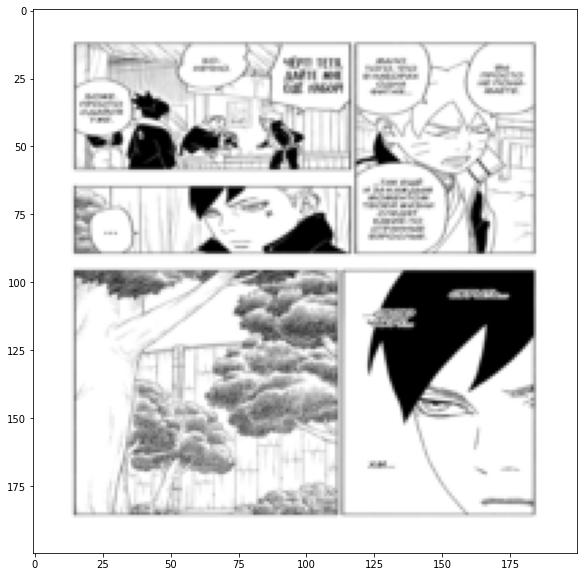

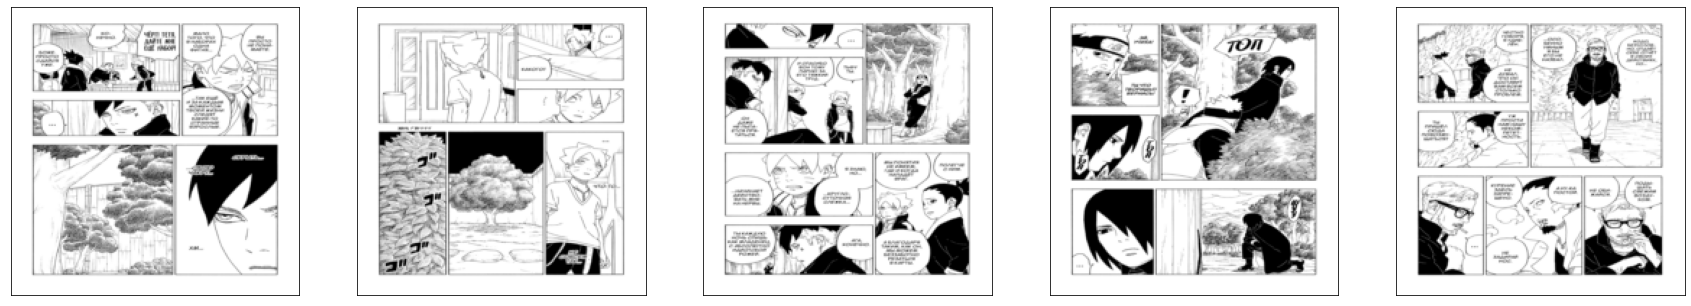

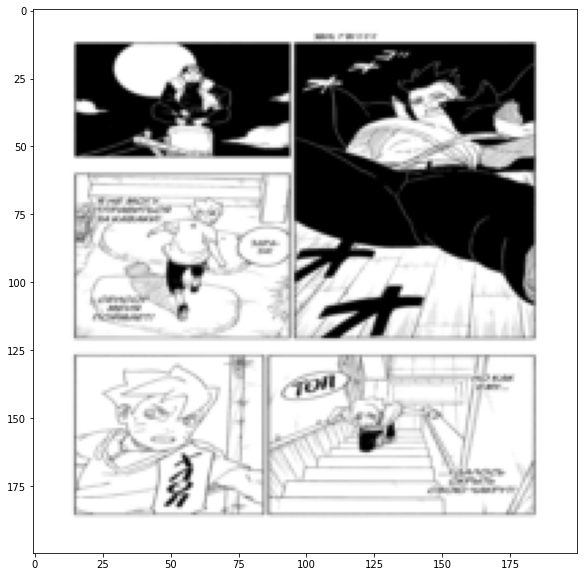

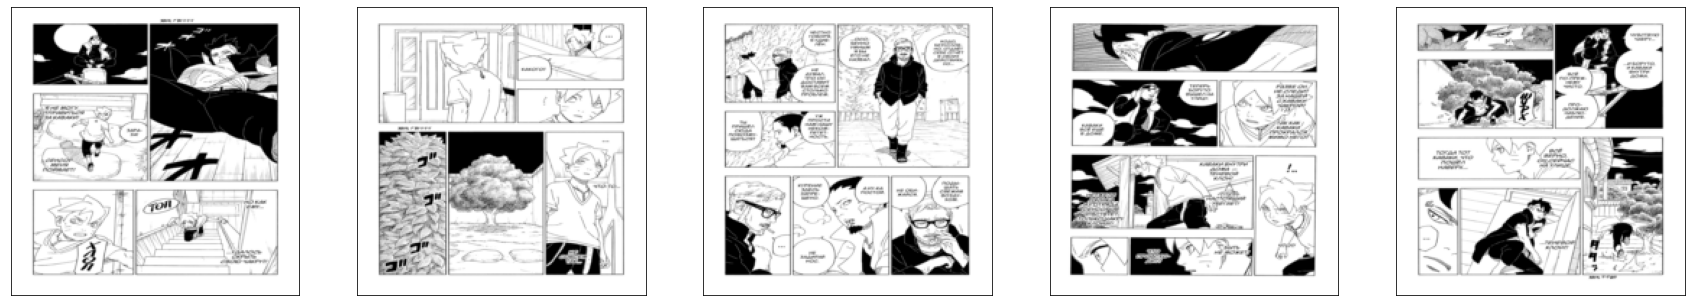

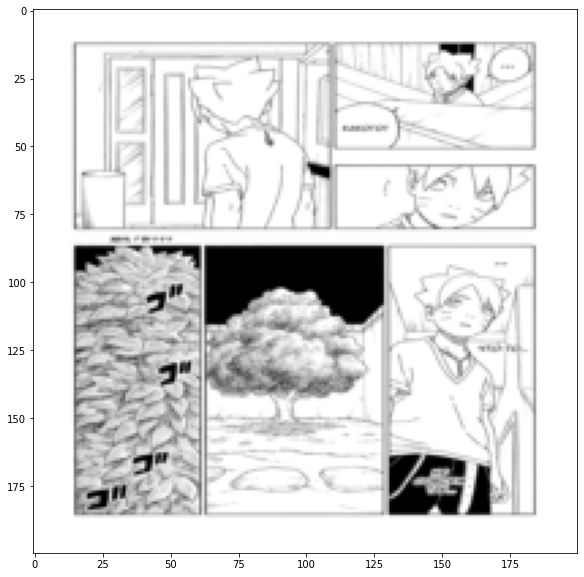

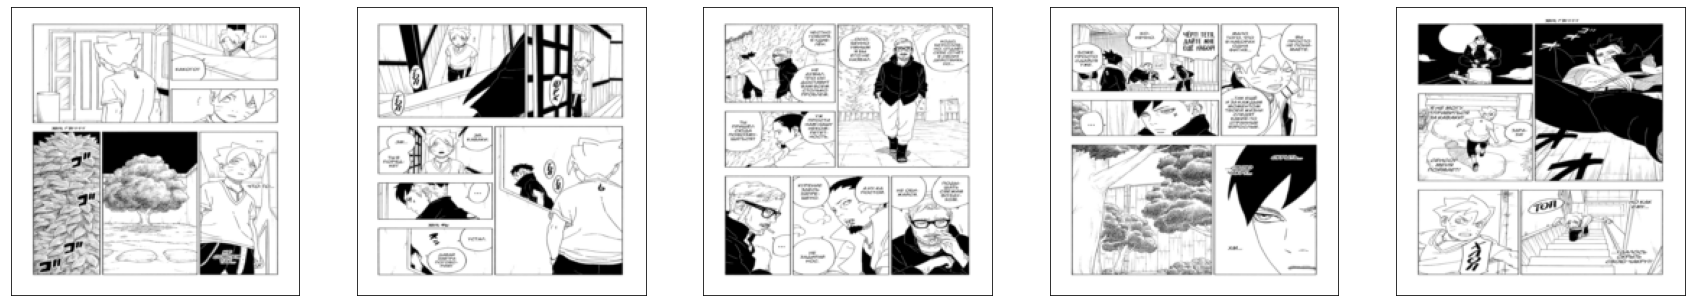

In [137]:
for idx, emb in enumerate(queries):
    # Extracting nns for each picture
    nns = index.get_nns_by_vector(emb, 5)
    # Showing original image
    plt.figure(figsize=(10, 10))
    plt.imshow(np.moveaxis(q_images[idx * 10], 0, -1))
    plt.show()
    # Showing retrieved images
    showInRow(g_images[nns], disable_ticks=True, figsize=(30,50))

**Important notes **

1. Deadline is ** 7th september at 10 AM**
2. Cheating is prohibited 

In [ ]:
from chatique import get, send
# send(“test+_message”)

In [ ]:
get(100)

Казыбекмамбетов: салам
Казыбекмамбетов: салам
Казыбекмамбетов: салам
Казыбекмамбетов: салам
казыбек: код нерабочий
казыбек: код нерабочий
всмысле нерабочий?: руслан
dainty-elastic: казыбек-боты
руслан: всмысле нерабочий?))))
руслан: АХАХХАХААХХАХА
руслан: какие боты блять аххаха
казыбек: ЗАПУСКАЕМ ГУСЯ СРУСЯ
░░░░░░░░░░░░▄▀▀▀▄░░░░░░░
░░░░░░░▄███▀░@(◐)░░░▌░░░░░
░░░░░░░░░░░▌░░░░░▐░░░░░
РАБОТЯГИ░░░▌░░░░▐░░░░░░
░░░░░░░░░░░█▀▀░░█░░░░░░
░░░░░░▄▀▀▀▀░░░░░█▄▄░░░░
░░░░░░█░█░░░░░░░░░░▐░░░
░░░░░░▐▐░░░░░░░░░▄░▐░░░
░░░░░░█░░░░░░░░▄▀▀░▐░░░
░░░░▄▀░░░░░░░░▐░▄▄▀░░░░
░░▄▀░░░▐░░░░░█▄▀░▐░░░░░
░░█░░░▐░░░░░░░░▄░█░░░░░
░░░█▄░░▀▄░░░░▄▀▐░█░░░░░
░░░█▐▀▀▀Ỏ͖͈̞̩͎̻̫̫̜͉̠̫͕̭̭̫̫̹̗̹͈̼̠̖͍͚̥͈̮̼͕̠̤̯̻̥̬̗̼̳̤̳̬̪̹͚̞̼̠͕̼̠̦͚̫͔̯̹͉͉̘͎͕̼̣̝͙̱̟̹̩̟̳̦̭͉̮̖̭̣̣̞̙̗̜̺̭̻̥͚͙̝̦̲̱͉͖͉̰̦͎̫̣̼͎͍̠̮͓̹̹͉̤̰̗̙͕͇͔̱͕̭͈̳̗̭͔̘̖̺̮̜̠͖̘͓̳͕̟̠̱̫̤͓͔̘̰̲͙͍͇̙͎̣̼̗̖͙̯͉̠̟͈͍͕̪͓̝̩̦̖̹̼̠̘̮͚̟͉̺̜͍͓̯̳̱̻͕̣̳͉̻̭̭̱͍̪̩̭̺͕̺̼̥̪͖̦̟͎̻̰▀▀▀▀░░▐░█░░░░░
░░▐█▐▄░░░░░░░░░▐░█▄▄░
3
Me gustaMostrar me gusta
keen-graceful: Пришли, пробежали, покакали
руслан: ЗАПУСКАЕМ ГУСЯ СРУСЯ
░░░░░░░░░░░░▄▀▀▀▄░